In [186]:
#built in librairies 
import re
from tqdm import tqdm

# pip libraires
import numpy as np
import json
import pandas as pd


# visualization librairies
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing Librairies
import nltk
from nltk.stem import WordNetLemmatizer, LancasterStemmer
from nltk.tokenize import word_tokenize
import re

import json
import requests
from collections import defaultdict

import pandas as pd

# Visualization librairies
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
import plotly.express as px

#Calculating libraries
from scipy.stats import bootstrap
import numpy as np
from scipy import stats
import scipy as sp
import matplotlib.dates as md

#statistical librairies
from os import stat

# Others
from functools import partial
from ast import literal_eval

# Import libraries
import requests
from bs4 import BeautifulSoup

# TODO define
#from genres import genre_wordsets
import csv
from tqdm import tqdm
import itertools
from dateutil.relativedelta import relativedelta
import datetime  
from scipy.stats import ttest_ind 

from utils.genres import additional_wordsets


In [187]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mohamedalidhraief/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mohamedalidhraief/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mohamedalidhraief/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Our dataset contains different datasets. We have:
- 
- 
- 
-
-


# Metadata

In [188]:
metadata = pd.read_table('./data/movie.metadata.tsv',header=None)
metadata.columns = ["wiki_id","freebase_id","movie_name","release_date","box_office","duration","language","country","genre"]


In [189]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wiki_id       81741 non-null  int64  
 1   freebase_id   81741 non-null  object 
 2   movie_name    81741 non-null  object 
 3   release_date  74839 non-null  object 
 4   box_office    8401 non-null   float64
 5   duration      61291 non-null  float64
 6   language      81741 non-null  object 
 7   country       81741 non-null  object 
 8   genre         81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


Here are our observations:
- Box Office contains mainly null values, so we drop the column.
- The type of the release_date is an object, we will transform it into a datetime to make sampling easier.

In [190]:
metadata.drop(columns="box_office",inplace=True)
metadata['release_date'] = pd.to_datetime(metadata['release_date'], errors = 'coerce')


In [191]:
metadata.head(1)

,wiki_id,freebase_id,movie_name,release_date,duration,language,country,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adv..."


We note that language, country, genre are JSONs. Therefore, we nede to transform them into a list

In [192]:
json_cols = ["language","country","genre"]
for col in json_cols:
    metadata[col] = metadata[col].apply(lambda x:list(json.loads(x).values()))

In [193]:
metadata.head()

,wiki_id,freebase_id,movie_name,release_date,duration,language,country,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western]"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thriller]"
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,106.0,[German Language],[Germany],[Drama]


We are aware that the columns can contain list with one value at a team. For simplicity of cleaning, we leave it llike that for the moment.

In [194]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list


In [195]:
genres =pd.Series(flatten_list(list(metadata.genre)))
n_genres = len(set(genres))
print("Number of genres: {} ".format(n_genres))

Number of genres: 363 


We have 363 genres. Some of them are quite specific : Homoeroticism,Silhouette animation and other are more general.
In order to have a deeper analysis for the genres, we need to link every genre into a metagenre. 

Therefore, we have created a mapping to the 363 genres to broader meta-genres.

## Metagenres

In [232]:
def stem_string(x:str)->list:
    """ Returns the stem of every word in the input

    Args:
        x (str): Contains the input to be stemmed

    Returns:
        _type_: a list of the words stemmed
    """
    
    stemmer = LancasterStemmer()
    words = word_tokenize(x)
    lemmatized_words = [stemmer.stem(word) for word in words]
    return lemmatized_words


#TODO NICO: 
- Rename clean_string and clean
- Explain the issue in science fiction in a mwrkdown
- Add type args and return as above

In [197]:
def clean_string(string):
    """_summary_

    Args:
        string (_type_): _description_

    Returns:
        _type_: _description_
    """
    clean_s = string.lower()
    clean_s = clean_s.replace('/', ' ')

    clean_s = re.sub(r'-(?!.*(fi|white))', ' ', clean_s)

    clean_s = re.sub(r'((?<=sci) (?=fi))|((?<=science) (?=fiction))', '-', clean_s)
    # remove everything except alphabets 
    clean_s = re.sub("[^a-zA-Z-]"," ",clean_s) 
    # remove whitespaces 
    clean_s = ' '.join(clean_s.split()) 
    return clean_s


In [198]:
def clean(var):

    out = ''

    if type(var) == list:
        out = var.copy()
        for i,s in enumerate(var):
            out[i] = clean_string(s)
    else :
        if type(var) == dict:
            out = var.copy()
            for key, value in var.items():
                out[clean_string(key)] = clean(value)
        else:
            out = clean_string(var)
    return out

Add explanation of what does the website contains.

Include picture if necessary

In [199]:
URL = 'https://www.studiobinder.com/blog/movie-genres-list/'

# Make the request
r = requests.get(URL) # /ip: Returns the requester's IP Address.


In [200]:
soup = BeautifulSoup(r.text, 'html.parser')
soup.h5.string

publications_wrappers = soup.find_all('div', {"data-css": ["tve-u-16d41491117", "tve-u-16d41ed6dc1", "tve-u-17317362207"]})

print('Total number of items: {0}'.format(len(publications_wrappers)))

genres = dict([])

for p in publications_wrappers[:-1]:    
    sub_g = p.find_all('h5')
    major_genres = p.find_all('h3')

    for g in major_genres :

        m_genre = clean(g.string.rsplit(' ', 1)[0])
        genres[m_genre] = []
        genres[m_genre].append(clean(m_genre))

    for s in sub_g :
        genres[m_genre].append(clean(s.string))

print(genres)

Total number of items: 14
{'action': ['action', 'heroic bloodshed', 'military action', 'espionage', 'wuxia action', 'disaster', 'adventure', 'superhero'], 'animation': ['animation', 'traditional', 'stop motion', 'claymation', 'cutout', 'computer generated imagery', 'puppetry', 'live action'], 'comedy': ['comedy', 'action comedy', 'dark comedy black comedy', 'romantic comedy', 'buddy comedy', 'road comedy', 'slapstick comedy', 'parody', 'spoof', 'satire', 'sitcom', 'sketch comedy', 'mockumentary', 'prank'], 'crime': ['crime', 'caper', 'heist', 'gangster', 'cop police', 'detective', 'courtroom', 'procedural'], 'drama': ['drama', 'melodrama', 'teen drama', 'philosophical drama', 'medical drama', 'legal drama', 'political drama', 'anthropological drama', 'religious drama', 'docudrama'], 'experimental': ['experimental', 'surrealist', 'absurdist'], 'fantasy': ['fantasy', 'contemporary fantasy', 'urban fantasy', 'dark fantasy', 'high fantasy', 'myth'], 'historical': ['historical', 'historical

In [201]:
def clean_confusing_genres(all_genres):

    key_list = list(all_genres.keys())
    key_list = [stem_string(key) for key in key_list]


    values_list = []
    for items in list(all_genres.values()) : 
        values_list += items

    for major_genres, sub_genres in all_genres.items() :
        
        temp_list = values_list.copy()
        stemmed_major_genre = stem_string(major_genres)

        for s_g in sub_genres :
            temp_list.remove(s_g)

            for composed_genres in temp_list :
                if s_g in composed_genres :
                    composed_genres.remove(s_g)
        
        temp_list = [x for x in temp_list if x]

        for s_g in sub_genres :

            for other_genres in temp_list :
                if (other_genres[0] in s_g) and (stemmed_major_genre[0] in s_g) :
                    s_g.remove(other_genres[0])

                if "film" in s_g :
                    s_g.remove("film")

                if "fict" in s_g :
                    s_g.remove("fict")

                for m_genres in key_list :
                    if m_genres[0] in s_g :
                        s_g.remove(m_genres[0])
            
        all_genres[major_genres].append(stemmed_major_genre)   
                
        all_genres[major_genres] = [x for x in sub_genres if x]

In [202]:
from utils.genres import additional_wordsets
additional_wordsets = additional_wordsets

def mergeDictionary(dict_1, dict_2):
   dict_3 = {**dict_1, **dict_2}
   for key, value in dict_3.items():
       if key in dict_1 and key in dict_2:
               dict_3[key] = value + dict_1[key]
   return dict_3

def stem_dictionary(dict):
    for key, values in dict.items() :
        dict[key] = [stem_string(v) for v in values]

In [203]:
genre_map = mergeDictionary(genres, clean(additional_wordsets))
stem_dictionary(genre_map)
clean_confusing_genres(genre_map)


In [204]:
global i 
i=0

def extract_genres(df_genres:object)->list:
    """ returns 1 if one pronoun in pronouns is in headline else 0

    Args:
        pronouns (list): list of pronouns
        headline (object): headline of the article

    Returns:
        list: 1 if there is a pronoun from pronouns in headline else 0 
    """
    genre_list = []
    input_genres = df_genres.copy()
    global i
    i +=1
    merged_stem_strings = [stem_string(clean(g)) for g in input_genres]

    for major_genres, sub_genres in genre_map.items() : 
        for s_g in sub_genres :
            for item in merged_stem_strings :
                if s_g[0] in item :
                    genre_list.append(major_genres)

    if len(genre_list) == 0 :
        genre_list.append("Other")

    genre_list = list(set(genre_list))

    return genre_list

In [205]:
metadata["metagenre"]=metadata["genre"].apply(extract_genres)

In [206]:
metadata.columns

Index(['wiki_id', 'freebase_id', 'movie_name', 'release_date', 'duration',
       'language', 'country', 'genre', 'metagenre'],
      dtype='object')

We will present an analysis for evolution of metagenres throughout the time in the Analysis Section.

# Plots

In [207]:
# read plots
plots = []
with open("data/plot_summaries.txt", 'r') as f:
    reader = csv.reader(f, dialect='excel-tab') 
    for row in tqdm(reader):
        plots.append(row)

movie_id = []
plot = []


42303it [00:00, 79020.02it/s]


In [208]:
# extract movie Ids and plot summaries
for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])


100%|██████████| 42303/42303 [00:00<00:00, 2644917.45it/s]


In [209]:
# create dataframe
plots = pd.DataFrame({'movie_id': movie_id, 'plot': plot})


In [210]:
def clean_text(text):
    # remove a string like {{plot}}
    text = re.sub("\s*{{\w*}}\s*", "", text)
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text)
    
    text = text.lower().replace('\n', ' ').replace('\t', ' ').replace('\xa0',' ') #get rid of problem chars
    
    text = ' '.join(text.split())
    
    return text

plots['plot'] = plots['plot'].apply(clean_text)


In [211]:
plots

,movie_id,plot
0,23890098,"shlykov, a hard-working taxi driver and lyosha, a saxophonist, develop a bizarre love-hate relat..."
1,31186339,the nation of panem consists of a wealthy capitol and twelve poorer districts. as punishment for...
2,20663735,poovalli induchoodan is sentenced for six years prison life for murdering his classmate. inducho...
3,2231378,"the lemon drop kid , a new york city swindler, is illegally touting horses at a florida racetrac..."
4,595909,"seventh-day adventist church pastor michael chamberlain, his wife lindy, their two sons, and the..."
...,...,...
42298,34808485,"the story is about reema , a young muslim schoolgirl in malabar, who loved malayalam and poetry...."
42299,1096473,"in 1928 hollywood, director leo andreyev looks through photographs for actors for his next movie..."
42300,35102018,american luthier focuses on randy parsons’ transformation from aspiring musician to guitar-maker...
42301,8628195,"abdur rehman khan , a middle-aged dry fruit seller from afghanistan, comes to calcutta to hawk h..."


# Characters

In [212]:
characters = pd.read_csv("data/character.metadata.tsv", sep = '\t', header = None)


In [213]:
characters.columns = ["wiki_movie_id","freebase_movie_id","release_date","character_name","date_birth","gender",
                      "height","ethnicity","act_name","act_age",
                      "freebase_char_actor_id","freebase_char_id","freebase_actor_id"]

In [214]:
characters.head()

,wiki_movie_id,freebase_movie_id,release_date,character_name,date_birth,gender,height,ethnicity,act_name,act_age,freebase_char_actor_id,freebase_char_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [215]:
characters.release_date = pd.to_datetime(characters.release_date, errors = 'coerce')
characters.date_birth =  pd.to_datetime(characters.date_birth , errors = 'coerce')

In [216]:
characters.head()

,wiki_movie_id,freebase_movie_id,release_date,character_name,date_birth,gender,height,ethnicity,act_name,act_age,freebase_char_actor_id,freebase_char_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26 00:00:00,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12 00:00:00,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25 00:00:00,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


# Analysis

## Evolution of genres throughout the year

In [217]:
metadata.columns

Index(['wiki_id', 'freebase_id', 'movie_name', 'release_date', 'duration',
       'language', 'country', 'genre', 'metagenre'],
      dtype='object')

In [218]:
dummies_genres = pd.get_dummies(metadata["metagenre"].explode()).sum(level=0)
metadata = metadata.join(dummies_genres)

/var/folders/gh/wp3trlqx0lzd727nqkyhfjqw0000gn/T/ipykernel_69606/554888437.py:1: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



In [219]:
cols_to_drop = ["movie_name","duration","language","country","genre","metagenre","wiki_id"]

genre_per_date = metadata.copy().drop(columns=cols_to_drop).set_index("release_date")
genre_per_date = genre_per_date.groupby("release_date").sum()
genre_per_date

/var/folders/gh/wp3trlqx0lzd727nqkyhfjqw0000gn/T/ipykernel_69606/4144096222.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,erotic,...,horror,musical,propaganda,religious,romance,science-fiction,silent,thriller,war,western
release_date,,,,,,,,,,,,,,,,,,,,,
1888-01-01,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1889-01-01,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1890-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1891-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1892-10-28,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2015-01-01,0,2,0,0,1,1,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
2016-01-01,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0


In [220]:
genre_per_date.head()

,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,erotic,...,horror,musical,propaganda,religious,romance,science-fiction,silent,thriller,war,western
release_date,,,,,,,,,,,,,,,,,,,,,
1888-01-01,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1889-01-01,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1890-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1891-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1892-10-28,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0


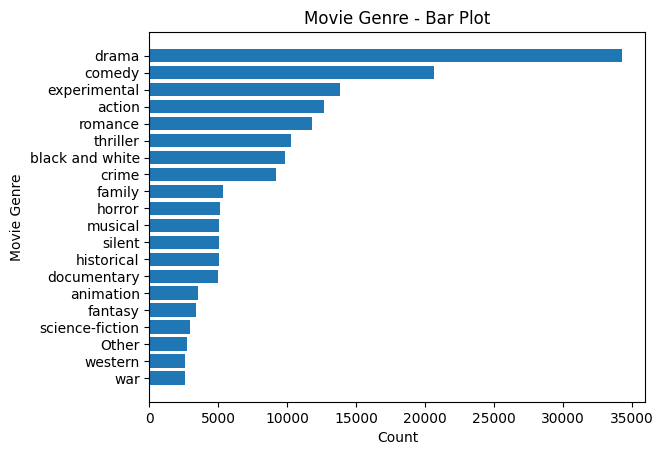

In [221]:
fig, ax = plt.subplots()
n_top_genres = 20 
sorted_genres = genre_per_data.sum(axis=0).sort_values(ascending=False)[:n_top_genres]

ax.barh(sorted_genres.index, sorted_genres.values, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_ylabel('Movie Genre')
ax.set_title('Movie Genre - Bar Plot')

plt.show()


We can note that genre, comedy and experimental are part of the top three genres. But what about their evolution throughout time?

In [222]:
# sample per period
window = "5Y"

# chose agg funct from aggfunct = [np.sum,np.cumsum]
cumfunc = pd.DataFrame.cummax

# normalize every period (sum of the row = 1)
normalize = False

# study the pct_change
pct_change_bool = False


In [223]:
def plot_line(df):
    fig = px.line(sum_y_genre)

    period = [1,3,5,10,20,30,50,100]
    # Create the financial buttons
    fin_buttons = [  {'count': y, 'label': str(y)+ "YTD", 'step': "year", 'stepmode': "todate"} for y in period ]

    # Create the date range buttons & show the plot
    fig.update_layout({'xaxis': {'rangeselector': {'buttons': fin_buttons}}})
    fig.show()

In [224]:
def genre_per_period(window:str,normalize:bool,pct_change_bool:bool,cumfunc=None):
    res = genre_per_date.resample(window).sum()
    if not cumfunc==None:
        res = res.apply(cumfunc)
    
    if normalize:
        res = res.div(sum_y_genre.sum(axis=1), axis=0)

    if pct_change_bool:
        res = res.pct_change().fillna(0)
    return res


In [225]:
plot_line(genre_per_period(window=window,cumfunc=cumfunc,normalize=normalize,pct_change_bool=pct_change_bool))

In [226]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   wiki_id          81741 non-null  int64         
 1   freebase_id      81741 non-null  object        
 2   movie_name       81741 non-null  object        
 3   release_date     74838 non-null  datetime64[ns]
 4   duration         61291 non-null  float64       
 5   language         81741 non-null  object        
 6   country          81741 non-null  object        
 7   genre            81741 non-null  object        
 8   metagenre        81741 non-null  object        
 9   Other            81741 non-null  uint8         
 10  action           81741 non-null  uint8         
 11  animation        81741 non-null  uint8         
 12  black and white  81741 non-null  uint8         
 13  comedy           81741 non-null  uint8         
 14  crime            81741 non-null  uint8

metadata.set_index(["release_date"]).count()

In [227]:
genre_per_date

,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,erotic,...,horror,musical,propaganda,religious,romance,science-fiction,silent,thriller,war,western
release_date,,,,,,,,,,,,,,,,,,,,,
1888-01-01,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1889-01-01,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1890-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1891-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1892-10-28,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2015-01-01,0,2,0,0,1,1,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
2016-01-01,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0


In [228]:
metadata[metadata.release_date.dt.year>2015]

,wiki_id,freebase_id,movie_name,release_date,duration,language,country,genre,metagenre,Other,...,horror,musical,propaganda,religious,romance,science-fiction,silent,thriller,war,western
30275,27554912,/m/0c03gcc,Kung Fu Panda 3,2016-03-18,NaN,[],[],[],[Other],1,...,0,0,0,0,0,0,0,0,0,0
34022,23124260,/m/064mmw7,Jeepers Creepers 4,2016-06-08,NaN,[],[United States of America],"[Thriller, Horror]","[thriller, horror]",0,...,1,0,0,0,0,0,0,1,0,0
64862,3139382,/m/08tyfg,Battle Angel,2016-01-01,NaN,[English Language],[United States of America],"[Thriller, Science Fiction, Action, Romance Film]","[action, science-fiction, thriller, romance]",0,...,0,0,0,0,1,1,0,1,0,0


In [241]:
test = genre_per_date.resample("Y").sum()
test["count"] = metadata.set_index(["release_date"]).resample("Y").count()["wiki_id"]
for col in test.columns:
    test[col] = test[col]/ test["count"]

In [244]:
test.max()

Other              0.333333
action             1.000000
animation          1.000000
black and white    1.000000
comedy             0.405640
crime              0.250000
diversity          0.049145
documentary        0.631579
drama              0.541702
erotic             0.083333
experimental       1.000000
family             0.116279
fantasy            0.285714
historical         0.115974
horror             0.333333
musical            0.229885
propaganda         0.099138
religious          0.058183
romance            0.333333
science-fiction    1.000000
silent             1.000000
thriller           0.666667
war                0.193966
western            0.162080
count              1.000000
dtype: float64

In [236]:
metadata.set_index(["release_date"]).resample("Y").count()

,wiki_id,freebase_id,movie_name,duration,language,country,genre,metagenre,Other,action,...,horror,musical,propaganda,religious,romance,science-fiction,silent,thriller,war,western
release_date,,,,,,,,,,,,,,,,,,,,,
1888-12-31,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1889-12-31,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1890-12-31,2,2,2,0,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1891-12-31,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1892-12-31,3,3,3,0,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31,1194,1194,1194,610,1194,1194,1194,1194,1194,1194,...,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194
2013-12-31,164,164,164,21,164,164,164,164,164,164,...,164,164,164,164,164,164,164,164,164,164
2014-12-31,17,17,17,0,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17


In [231]:
metadata.wiki_id.count()

81741